In [1]:
%matplotlib inline
import numpy as np
import scipy.io as scio
import math as mt
import sys
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy as sc
import seaborn as sns
import pylab
#from sklearn import linear_model

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## Set de datos de bicicleta eléctrica ##
#mat = scio.loadmat('bicycleData.mat')
#dataset = 'sim11'
database = 'bicicleta5.mat'
mat = scio.loadmat(database)
dataset = 'bicicleta'
print(np.shape(mat[dataset]))
if database == 'bicicleta.mat':
    simLength = len(mat[dataset][145:7814,0])
if database == 'bicicleta5.mat':
    simLength = len(mat[dataset][:,0])
print("Largo de serie de datos")
print(simLength)
sampleRes = 1
t = np.arange(0,simLength/sampleRes,1/sampleRes)
## Porcentaje de datos a mostrar el error ##
desiredPercent = 0.8
percentError = 1-desiredPercent

### Datos serie bicicleta ###
if database == 'bicicleta.mat':
    x = mat[dataset][145:7814,0]
    y = mat[dataset][145:7814,1]
    z = mat[dataset][145:7814,2]
if database == 'bicicleta5.mat':
    x = mat[dataset][:,0]
    y = mat[dataset][:,1]
    z = mat[dataset][:,2]
    a = mat[dataset][:,3]

x=x-np.mean(x); x=x/np.std(x)
y=y-np.mean(y); y=y/np.std(y)
z=z-np.mean(z); z=z/np.std(z)
if database == 'bicicleta3.mat':
    a=a-np.mean(a); a=a/np.std(a)

#signal = [x,y,z]#,a]
if database == 'bicicleta.mat':
    signal = [x,y]
if database == 'bicicleta5.mat':
    signal = [x,y,a]
signal = np.array(signal)

devChannel = np.sqrt(0.7)
std_1 = devChannel
std_2 = devChannel
std_3 = devChannel

r1 = np.random.normal(0,std_1**2,len(t))
r2 = np.random.normal(0,std_2**2,len(t))
r3 = np.random.normal(0,std_3**2,len(t))

x_noise = x #+ r1
y_noise = y #+ r2
z_noise = z #+ r3
if database == 'bicicleta5.mat':
    a_noise = a
print(np.shape(signal))

(7669, 4)
Largo de serie de datos
7669
(3, 7669)


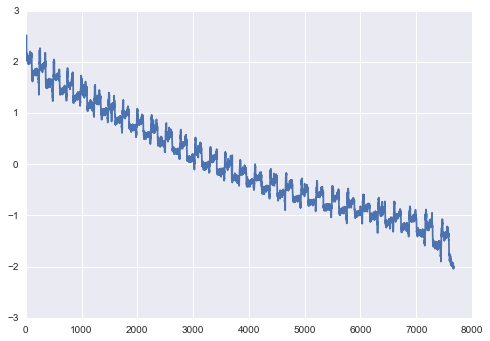

In [3]:
plt.plot(y)
plt.show()

In [4]:
# en esta celda es solo inicialización: 
# se importan paquetes a utilizar y se definen funciones que serán requeridas más tarde. 
# Ver comentarios en cada unas de las funciones.


#esta línea indica que las figuras se muestran en el notebook
%matplotlib inline 

import numpy as np
from numpy import *
import scipy
from scipy.optimize import fmin_l_bfgs_b as fmin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#import seaborn as sns #- uncomment this if you want to use seaborn for better-looking plots
import os
import time


def SE(a,b,gamma=1./2,sigma=1): 
	#Square Exponential kernel

	#returns the evaluation of the kernel
	#k(a,b)=sigma**2*exp(-gamma*(a-b)**2), 
	#notice that in this definition gamma = 1 /(2*lengthscale**2), in order to simplify the derivatives
	#for consistency with the generation of Gram matrices, this function returns
	#a matrix of dimensions dim(a) x dim(b);  
  
	#INPUTS
	#a,b are column vectors of (possibly) different lenghts
	sa=np.size(a); sb=np.size(b)

	if sa==1: a=np.array([a])
	if sb==1: b=np.array([b])
	K=np.zeros([sa,sb])
	#accelerate computation if a==b
	if np.array_equal(a,b):
		for va in range(sa):
			K[va,va]=1;
			for vb in range(va+1,sb):
				K[va,vb]=exp(-(a[va]-b[vb])**2*gamma)
				K[vb,va]=K[va,vb]
	#a!=b
	else:
		for va in range(sa):
			for vb in range(sb):
				K[va,vb]=exp(-(a[va]-b[vb])**2*gamma);
	if sa==1:
		return sigma**2*np.reshape(K,b.shape)
	elif sb==1:
		return sigma**2*np.reshape(K,a.shape)
	else:
		return sigma**2*K

#negative log-likelihood when using SE kernel
def like_SE(X, y, t): 

    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
	sigma_noise, gamma_1, sig_1 = np.exp(X)     
	Gram=SE(t,t,gamma=gamma_1,sigma=sig_1)+sigma_noise**2*np.identity(len(t))
	print(np.all(Gram>0))
	print(np.min(Gram))
	print(np.shape(Gram))
	print(Gram[:3,:3])
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
	return 0.5*nll+0.5*len(y)*np.log(2*pi)

#derivative of negative log-likelihood when using SE kernel
def like_SE_Df(X, y, t):
	sigma_noise, gamma_1, sig_1 = np.exp(X)
	Gram0=SE(t,t,gamma=gamma_1,sigma=sig_1)
	Gram=Gram0+sigma_noise**2*np.identity(len(t))
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	A=np.dot(invGram,y)
	outer_sub=outersum(t,-t)
	D1=2*sigma_noise**2*np.identity(len(t)) #sigma_noise
	D2=-Gram0*outer_sub**2*gamma_1 #gamma_1
	D3=2*Gram0 #sig_1 

	B=np.outer(A,A)-invGram
	d1=  -np.trace(np.dot(B,D1))
	d2=  -np.trace(np.dot(B,D2))
	d3=  -np.trace(np.dot(B,D3))
   	#print(['Derivatives: ', d1, d2, d3])
	return np.asarray([0.5*d1, 0.5*d2, 0.5*d3])
    
# "suma" externa
def outersum(a,b):
	return np.outer(a,ones_like(b))+np.outer(ones_like(a),b)

In [5]:
# Esta celda lee datos del archivo hr2.txt, los que corresponden a una señal de frecuencia cardíaca.
# Luego, se elige un subconjunto de los valores de la señal que representa las observaciones disponibles
# la señal completa es graficada en negro y las observaciones en rojo

#hr=[] #init array
#for line in open('hr2.txt', 'r'): #abre archivo
#	item = line.rstrip() 	# lee línea
#	hr.append(float(item)) #convierte a float
y=np.asarray(y); y=y-mean(y); y=y/std(y)  # convierte a array y normaliza (opcional)
f=y #señal es igual a versión ruidosa
N=len(y); T0=0; TF=N # inicio, fin y tamaño
t=np.arange(N) #vector de tiempo

#elección (aleatoria)del 15% de las muestras 
i_obs=np.random.choice(arange(0,N,1),0.15*N,replace=False)
N_obs=len(i_obs)
t_obs=t[i_obs]
y_obs=y[i_obs]#; y_obs.reshape(N_obs,1)



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


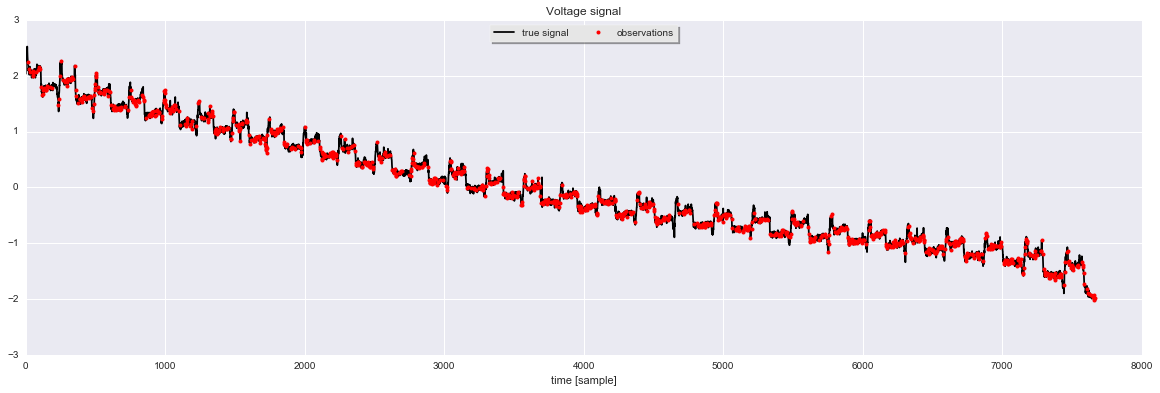

In [6]:
#gráfico
fig=plt.figure(1, figsize=(20,6))
ax = plt.gca()
plt.plot(t,f, color='black',ls='-',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Voltage signal')
plt.show()

In [7]:
#elegir hiperparámetros
sigma_y_GP_test = 0.2
gamma_test = 0.01
sigma_test= 0.5

#NLL para la elección de hiperparámetros 
print(like_SE([sigma_y_GP_test, gamma_test, sigma_test], y_obs, t_obs))


cov=SE(t,t,gamma=gamma_test,sigma=sigma_test)
cov_obs=SE(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test)
K_star=SE(t,t_obs,gamma=gamma_test,sigma=sigma_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

False
0.0
(1150, 1150)
[[ 4.21010653  0.          0.        ]
 [ 0.          4.21010653  0.        ]
 [ 0.          0.          4.21010653]]
2006.12726236


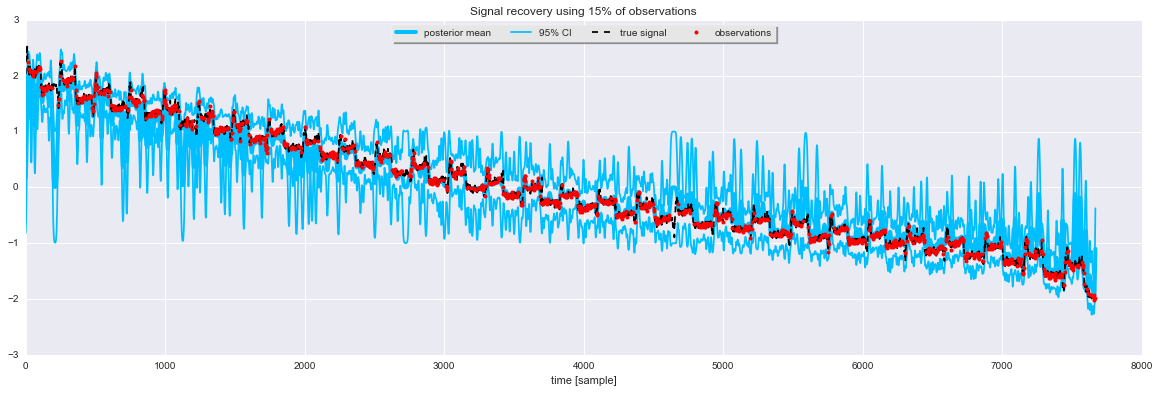

In [8]:
#graficar estimación, observaciones y datos reales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE.eps",format='eps', dpi=1000)

In [9]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_SE=0
params0=np.asarray([sigma_y_GP_test,  gamma_test,  sigma_test])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
X_opt, f_GP, data=fmin(like_SE,X0,like_SE_Df, args,disp=1,factr=0.00000001/(2.22E-12),maxiter=50)
time_GP=time.time()-time_GP
time_SE = time_GP
sigma_y_GP, gamma_1, sig_1 = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt), 'NLL: ', f_GP)
print('Tiempo transcurrido %f' %time_SE)

('Condicion inicial optimizador: ', array([ 0.2 ,  0.01,  0.5 ]))
False
0.0
(1150, 1150)
[[ 0.29  0.    0.  ]
 [ 0.    0.29  0.  ]
 [ 0.    0.    0.29]]
False
0.0
(1150, 1150)
[[ 1.22437923  0.          0.        ]
 [ 0.          1.22437923  0.        ]
 [ 0.          0.          1.22437923]]
False
0.0
(1150, 1150)
[[ 1.18775908  0.          0.        ]
 [ 0.          1.18775908  0.        ]
 [ 0.          0.          1.18775908]]
False
0.0
(1150, 1150)
[[  1.07770861e+000   6.24502960e-133   0.00000000e+000]
 [  6.24502960e-133   1.07770861e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   1.07770861e+000]]
False
0.0
(1150, 1150)
[[ 1.14062169  0.          0.        ]
 [ 0.          1.14062169  0.        ]
 [ 0.          0.          1.14062169]]
True
9.99354441451e-112
(1150, 1150)
[[  8.53371609e-01   1.59191631e-01   2.73461208e-96]
 [  1.59191631e-01   8.53371609e-01   2.49632393e-80]
 [  2.73461208e-96   2.49632393e-80   8.53371609e-01]]
False
0.0
(1150, 1150)
[[  1.

In [10]:
#Graficar nuevamente con los hiperparámetros encontrados mediante máxima verosimilitud
cov=SE(t,t,gamma=gamma_1,sigma=sig_1)
cov_obs=SE(t_obs,t_obs,gamma=gamma_1,sigma=sig_1)
K_star=SE(t,t_obs,gamma=gamma_1,sigma=sig_1)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

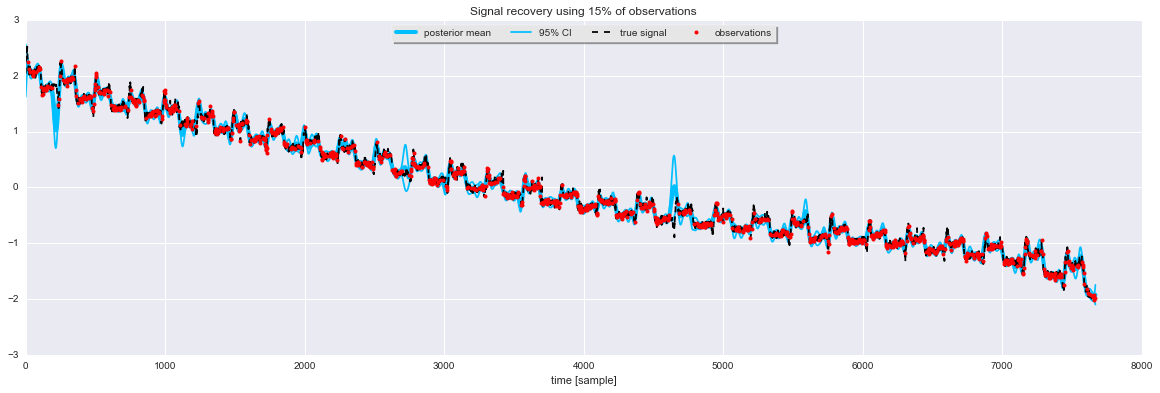

In [11]:
#plotear estimacion, observaciones y datos totales
fig=plt.figure(3, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE_post.eps",format='eps', dpi=1000)

# Predicción a partir de datos de entrenamiento#

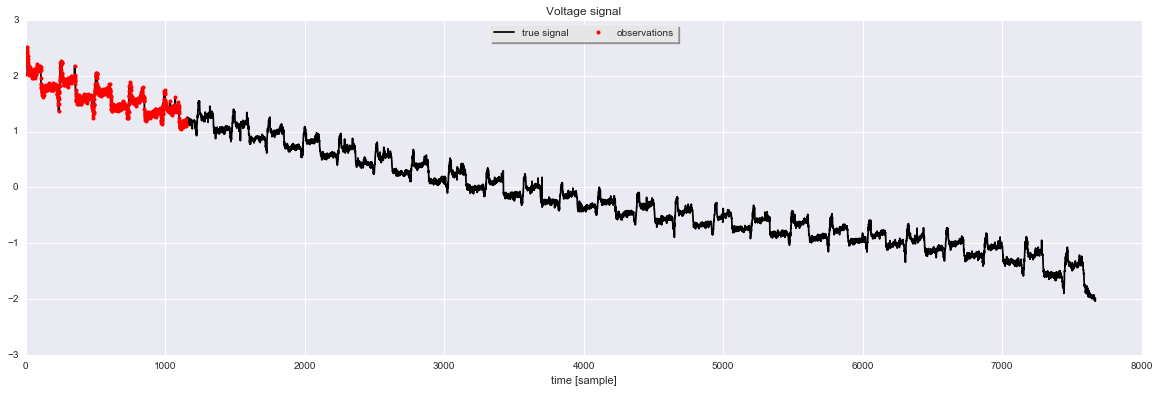

In [12]:
# Esta celda lee datos del archivo hr2.txt, los que corresponden a una señal de frecuencia cardíaca.
# Luego, se elige un subconjunto de los valores de la señal que representa las observaciones disponibles
# la señal completa es graficada en negro y las observaciones en rojo

#hr=[] #init array
#for line in open('hr2.txt', 'r'): #abre archivo
#	item = line.rstrip() 	# lee línea
#	hr.append(float(item)) #convierte a float
#y=np.asarray(y); y=y-mean(y); y=y/std(y)  # convierte a array y normaliza (opcional)
f=y #señal es igual a versión ruidosa
N=len(y); T0=0; TF=N # inicio, fin y tamaño
t=np.arange(N) #vector de tiempo

#elección (aleatoria)del 15% de las muestras 
#i_obs=np.random.choice(arange(0,N,1),0.15*N,replace=False)
i_obs = np.arange(int(.15*N))
N_obs=len(i_obs)
t_obs=t[i_obs]
y_obs=y[i_obs]#; y_obs.reshape(N_obs,1)

#gráfico
fig=plt.figure(1, figsize=(20,6))
ax = plt.gca()
plt.plot(t,f, color='black',ls='-',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Voltage signal')
plt.show()

False
0.0
(1150, 1150)
[[ 4.21010653  0.99000017  0.04782529]
 [ 0.99000017  4.21010653  0.99000017]
 [ 0.04782529  0.99000017  4.21010653]]
2099.06407973


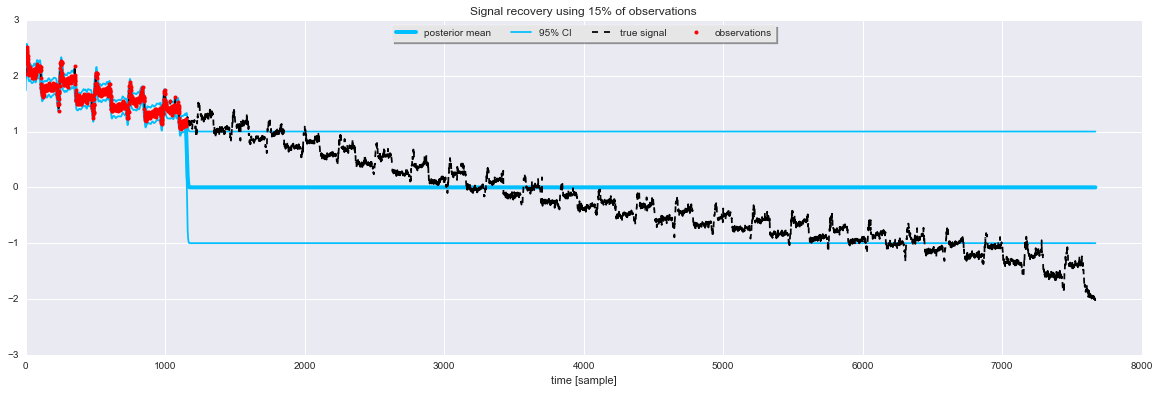

In [13]:
#elegir hiperparámetros
sigma_y_GP_test = 0.2
gamma_test = 0.01
sigma_test= 0.5

#NLL para la elección de hiperparámetros 
print(like_SE([sigma_y_GP_test, gamma_test, sigma_test], y_obs, t_obs))


cov=SE(t,t,gamma=gamma_test,sigma=sigma_test)
cov_obs=SE(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test)
K_star=SE(t,t_obs,gamma=gamma_test,sigma=sigma_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

#graficar estimación, observaciones y datos reales
fig=plt.figure(4, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE.eps",format='eps', dpi=1000)

In [14]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_SE=0
params0=np.asarray([sigma_y_GP_test,  gamma_test,  sigma_test])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
X_opt, f_GP, data=fmin(like_SE,X0,like_SE_Df, args,disp=1,factr=0.00000001/(2.22E-12),maxiter=50)
time_GP=time.time()-time_GP
time_SE = time_GP
sigma_y_GP, gamma_1, sig_1 = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt), 'NLL: ', f_GP)
print('Tiempo transcurrido %f' %time_SE)

('Condicion inicial optimizador: ', array([ 0.2 ,  0.01,  0.5 ]))
False
0.0
(1150, 1150)
[[ 0.29        0.24751246  0.24019736]
 [ 0.24751246  0.29        0.24751246]
 [ 0.24019736  0.24751246  0.29      ]]
False
0.0
(1150, 1150)
[[ 0.66985978  0.65720188  0.64176369]
 [ 0.65720188  0.66985978  0.65720188]
 [ 0.64176369  0.65720188  0.66985978]]
False
0.0
(1150, 1150)
[[ 1.13925716  1.13572098  1.12520853]
 [ 1.13572098  1.13925716  1.13572098]
 [ 1.12520853  1.13572098  1.13925716]]
False
0.0
(1150, 1150)
[[ 0.76991217  0.7639988   0.75008912]
 [ 0.7639988   0.76991217  0.7639988 ]
 [ 0.75008912  0.7639988   0.76991217]]
False
0.0
(1150, 1150)
[[ 0.80402298  0.79792679  0.78493575]
 [ 0.79792679  0.80402298  0.79792679]
 [ 0.78493575  0.79792679  0.80402298]]
False
0.0
(1150, 1150)
[[ 0.87371096  0.86813539  0.85681688]
 [ 0.86813539  0.87371096  0.86813539]
 [ 0.85681688  0.86813539  0.87371096]]
False
0.0
(1150, 1150)
[[ 1.218398    1.21423518  1.20774256]
 [ 1.21423518  1.218398   

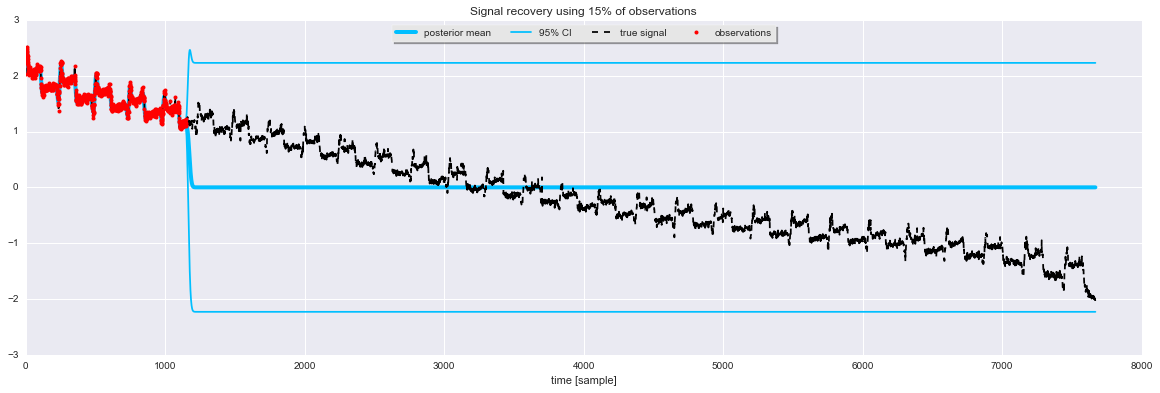

In [15]:
#Graficar nuevamente con los hiperparámetros encontrados mediante máxima verosimilitud
cov=SE(t,t,gamma=gamma_1,sigma=sig_1)
cov_obs=SE(t_obs,t_obs,gamma=gamma_1,sigma=sig_1)
K_star=SE(t,t_obs,gamma=gamma_1,sigma=sig_1)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

#plotear estimacion, observaciones y datos totales
fig=plt.figure(5, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE_post.eps",format='eps', dpi=1000)

## Ajuste de tendencia cuadrático ## 

In [16]:
y = y
x = t

In [17]:
sampleNum = len(y)
print(np.shape(x))
print(np.shape(y))
X1 = np.asarray([np.ones(sampleNum),x]).T
X2 = np.asarray([np.ones(sampleNum),x,x**2]).T
X3 = np.asarray([np.ones(sampleNum),x,x**2,x**3]).T
X4 = np.asarray([np.ones(sampleNum),x,x**2,x**3,x**4]).T
X5 = np.asarray([np.ones(sampleNum),x,x**2,x**3,x**4,x**5]).T

polynoms = [X1,X2,X3,X4,X5]

(7669,)
(7669,)


In [18]:
ratio = 1
w = []
for i in range(5):
    upper = np.dot(y,polynoms[i])
    lower = np.dot(polynoms[i].T,polynoms[i])
    lowerConstant = ratio*np.eye(i+2)
    w.append(np.dot(np.linalg.inv(lower-lowerConstant),upper))
print("Modelos obtenidos")
print("Orden 1 %s" %w[0])
print("Orden 2 %s" %w[1])
print("Orden 3 %s" %w[2])
print("Orden 4 %s" %w[3])
print("Orden 5 %s" %w[4])

Modelos obtenidos
Orden 1 [  1.69744661e+00  -4.42677432e-04]
Orden 2 [  1.99228153e+00  -6.73317524e-04   3.00743373e-08]
Orden 3 [  2.09261690e+00  -8.30265250e-04   8.12340362e-08  -4.44731594e-12]
Orden 4 [  1.96893915e+00  -5.07914944e-04  -1.07885236e-07   3.39113677e-11
  -2.50089214e-15]
Orden 5 [  1.97237621e+00  -5.15897620e-04  -1.04825289e-07   3.38724934e-11
  -2.54421169e-15  -2.99862392e-21]


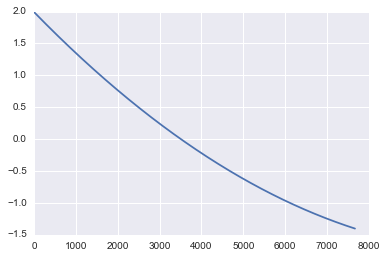

In [19]:
plt.plot(x,np.dot(polynoms[1],w[1]))
plt.show()

(7669, 1)
(7669,)


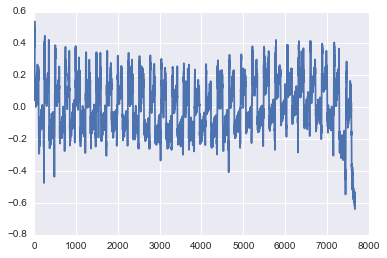

In [20]:
#regr = linear_model.LinearRegression()
t_new = t[:,np.newaxis]
print(np.shape(t_new))
print(np.shape(y))
#regr.fit(t_new, y)
y_trend = np.dot(polynoms[1],w[1])
plt.plot(y-y_trend)
plt.show()

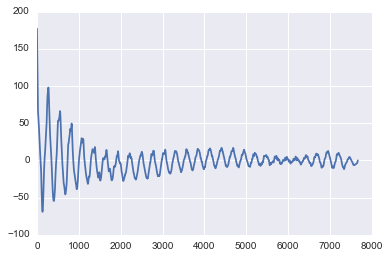

In [21]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]
y_new = y-y_trend
signal_autocorr = autocorr(y_new)
plt.plot(signal_autocorr)
plt.show()

Parámetros para ajustar el entrenamiento 

In [22]:
#Ns = 2*.066*N
Ns = 1000
Ns = int(Ns)
Ns_p = 2
print(Ns)

1000


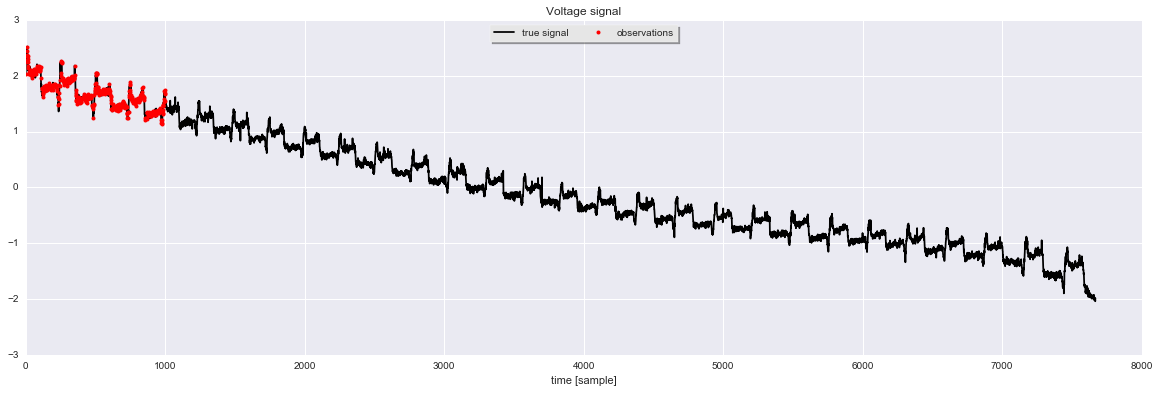

In [23]:
#elección (secuencial) del 15% de las muestras 
#i_obs=np.random.choice(arange(0,N,1),0.15*N,replace=False)
#i_obs = np.arange(int(2*.066*N))
#N_obs=len(i_obs)
#t_obs=t[i_obs]
#y_obs=y_new[i_obs]#; y_obs.reshape(N_obs,1)
#y_trend_comp = y_obs+y_trend[:len(i_obs)]

#elección (aleatoria)del 15% de las muestras 
i_obs=np.random.choice(arange(0,Ns,1),Ns/Ns_p,replace=False)
N_obs=len(i_obs)
t_obs=t[i_obs]
y_obs=y_new[i_obs]#; y_obs.reshape(N_obs,1)
y_trend_comp = y_obs+y_trend[i_obs]

#gráfico
fig=plt.figure(6, figsize=(20,6))
ax = plt.gca()
plt.plot(t,f, color='black',ls='-',label='true signal')
plt.plot(t_obs,y_trend_comp,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Voltage signal')
plt.show()

In [24]:
#elegir hiperparámetros
sigma_y_GP_test = 0.2
gamma_test = 0.01
sigma_test= 0.5

#NLL para la elección de hiperparámetros 
print(like_SE([sigma_y_GP_test, gamma_test, sigma_test], y_obs, t_obs))


cov=SE(t,t,gamma=gamma_test,sigma=sigma_test)
cov_obs=SE(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test)
K_star=SE(t,t_obs,gamma=gamma_test,sigma=sigma_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)


False
0.0
(500, 500)
[[ 4.21010653  0.          0.99000017]
 [ 0.          4.21010653  0.        ]
 [ 0.99000017  0.          4.21010653]]
813.339481874


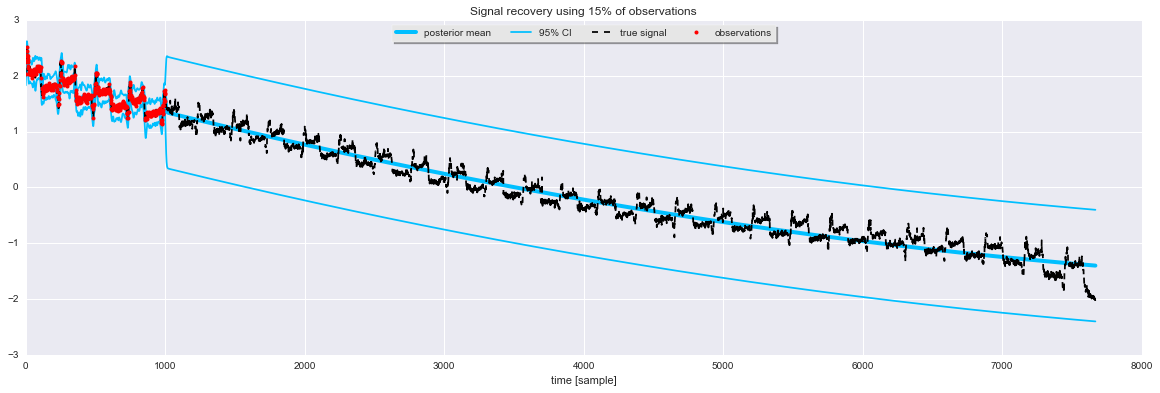

In [25]:
y_model_trend = y_model+y_trend
#graficar estimación, observaciones y datos reales
fig=plt.figure(7, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model_trend,c='#00BFFF',	lw=4,label='posterior mean')
plt.plot(t,y_model_trend+2*std_dev,c='#00BFFF',label='95% CI')
plt.plot(t,y_model_trend-2*std_dev,c='#00BFFF')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_trend_comp,'r.',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9)
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]')
plt.title('Signal recovery using 15% of observations')
plt.savefig("SE.eps",format='eps', dpi=1000)

## Kernel Periodic ##

$$K_{Per}(t_1,t_2)= \sigma^2 \exp\left(-2 \gamma \sin^{2}(\pi \vert t_1-t_2 \vert p^{-1})\right)$$

$$ NLL = \frac{1}{2} y_{obs}^T  K(t_{obs},t_{obs})^{-1} y_{obs} + \frac{1}{2} \log \vert K(t_{obs},t_{obs}) \vert + \frac{N}{2} \log(2 \pi)$$

Sean $z = -2 \gamma \sin^{2}(\pi \vert t_1-t_2 \vert p^{-1})$, $q = \pi \vert t_1-t_2 \vert p^{-1}$
\begin{align}
    \frac{\partial K_{Per}(t_1,t_2)}{\partial \sigma} & = 2 \sigma \exp(z) \\
    \frac{\partial K_{Per}(t_1,t_2)}{\partial \gamma} & = -\sigma^{2} \exp(z) \frac{z}{\gamma} \\
    \frac{\partial K_{Per}(t_1,t_2)}{\partial p} & = 4\gamma\sigma^{2} \exp(z) \sin(q) \cos(q) \frac{q}{p}
\end{align}

In [27]:
def Per(x, y, gamma, sigma, per):
    sx=np.size(x); sy=np.size(y)
    K = np.zeros([sx,sy])
#    print(sx)
#    print(sy)
    for i in range(sx):
        for j in range(sy):
            arg = np.sin(np.pi*np.abs(x[i]-y[j])/per)**2
            K[i,j] = np.exp(-2*gamma*(arg))
    return sigma**2*K 

def Per_diag(x, y, gamma, sigma, per):
    sx=np.size(x); sy=np.size(y)
    K = np.zeros([sx,sy])
#    print(sx)
    for i in range(sx):
        arg = np.sin(np.pi*np.abs(x[i]-y[i])/per)**2
        K[i,i] = np.exp(-2*gamma*(arg))
    return sigma**2*K 
def like_Per(X, y, t): 
    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
	sigma_un, gamma_1, sigma_1, per_1 = np.exp(X)     
	Gram=Per(t,t,gamma_1,sigma_1,per_1)+sigma_un**2*np.identity(len(t));
	check = np.linalg.eigvalsh(Gram)
	print(np.all(check>0))
	print(np.min(check))
	print(sigma_un)
#	print(np.shape(Gram))
	print(np.linalg.norm(Gram-Gram.T))
	print(sigma_un, gamma_1, sigma_1, per_1)
	cGg = sc.linalg.cholesky(Gram, lower=True)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	#invGram=np.linalg.inv(Gram)
	nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
	return 0.5*nll+0.5*len(y)*np.log(2*pi)

#derivative of negative log-likelihood when using Per kernel
def like_Per_Df(X, y, t):
	sigma_un, gamma_1, sigma_1, per_1 = np.exp(X)
	per_1 = 1/per_1    
	per_1 = 250
	Gram0=Per(t,t,gamma_1,sigma_1,per_1)
	Gram=Gram0+sigma_un**2*np.identity(len(t));
	check = np.linalg.eigvalsh(Gram)
	print(np.all(check>0))
	print(np.min(check))
	print(sigma_un)
#	print(np.shape(Gram))
	print(np.linalg.norm(Gram-Gram.T))
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	#invGram = np.linalg.norm(Gram)
	A=np.dot(invGram,y)
	outer_sub=outersum(t,-t)
	q = np.pi*per_1*outer_sub
	z = -2*gamma_1*np.sin(q)
	D1= 2*sigma_un**2*np.identity(len(t)) #sigma_un
	D2= -Gram0*z/gamma_1*sigma_1**2 #gamma_1
	D3= 2*Gram0*sigma_1**2 #sigma_1
	D4= 4*Gram0*gamma_1*np.sin(q)*np.cos(q)*q/per_1*sigma_1**2 #per_1

	B=np.outer(A,A)-invGram
	d1=  -np.trace(np.dot(B,D1))
	d2=  -np.trace(np.dot(B,D2))
	d3=  -np.trace(np.dot(B,D3))
	d4=  0#-np.trace(np.dot(B,D4))
   	#print(['Derivatives: ', d1, d2, d3])
	return np.asarray([0.5*d1, 0.5*d2, 0.5*d3, 0.5*d4])

In [29]:
#elegir hiperparámetros
sigma_y_GP_test = 1e0#0.2
gamma_test = 3e0#0.001
sigma_test = 0.3e0#0.5
per_test = 2.5e2#0.5


#NLL para la elección de hiperparámetros 
print(like_Per([sigma_y_GP_test, gamma_test, sigma_test, per_test], y_obs, t_obs))


cov=Per_diag(t,t,gamma=gamma_test,sigma=sigma_test,per=per_test)
cov_obs=Per(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test,per=per_test)
K_star=Per(t,t_obs,gamma=gamma_test,sigma=sigma_test,per=per_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
Gram = cov_obs+sigma_y_GP_test**2*np.identity(N_obs)
#invGramg = np.linalg.inv(Gram)
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)
y_model_trend = y_model+y_trend
print("Done")

True
7.38905609893
2.71828182846
0.0
(2.7182818284590451, 20.085536923187668, 1.3498588075760032, 3.7464546145026734e+108)
962.71634004
Done


(1, 7669)


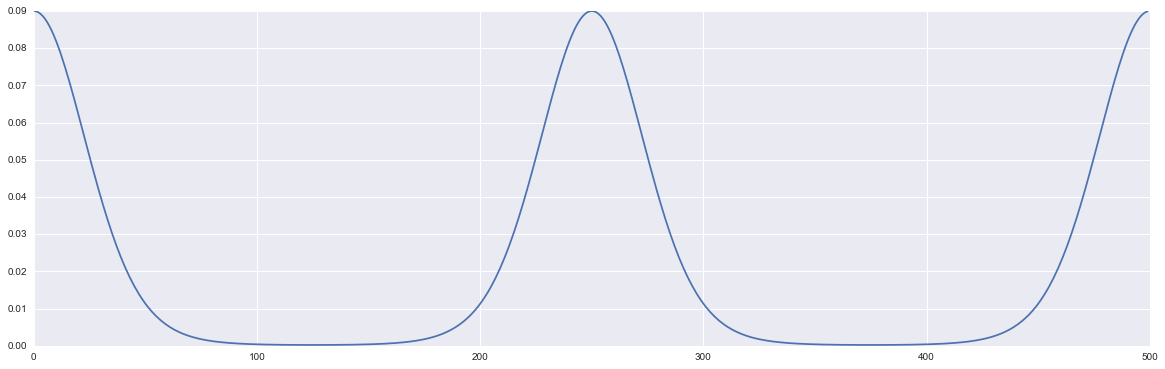

In [30]:
fig=plt.figure(8, figsize=(20,6))
#plt.plot(Per(np.array([0]),t,gamma=gamma_test,sigma=sigma_test,per=per_test))
print np.shape(Per(np.array([0]),t,gamma=gamma_test,sigma=sigma_test,per=per_test))
aux = Per(np.array([0]),t,gamma=gamma_test,sigma=sigma_test,per=per_test)
plt.plot(aux[0][:500])

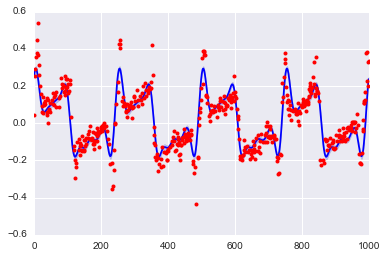

True
7.38905609893
2.71828182846
0.0
(2.7182818284590451, 20.085536923187668, 1.3498588075760032, 3.7464546145026734e+108)
962.71634004


In [31]:
plt.plot(t[:Ns],y_model[:Ns],'b',label='predicted mean')
plt.fill_between(t[:Ns],y_model[:Ns]-2*std_dev[:Ns], y_model[:Ns]+2*std_dev[:Ns], facecolor='blue', alpha=0.2)
plt.plot(t_obs,y[i_obs]-y_trend[i_obs],'r.',ms=8,label='observations')
#plt.plot(y_model)
#plt.plot(y[:500]-y_trend[:500])
plt.show()
print(like_Per([sigma_y_GP_test, gamma_test, sigma_test, per_test], y_obs, t_obs))

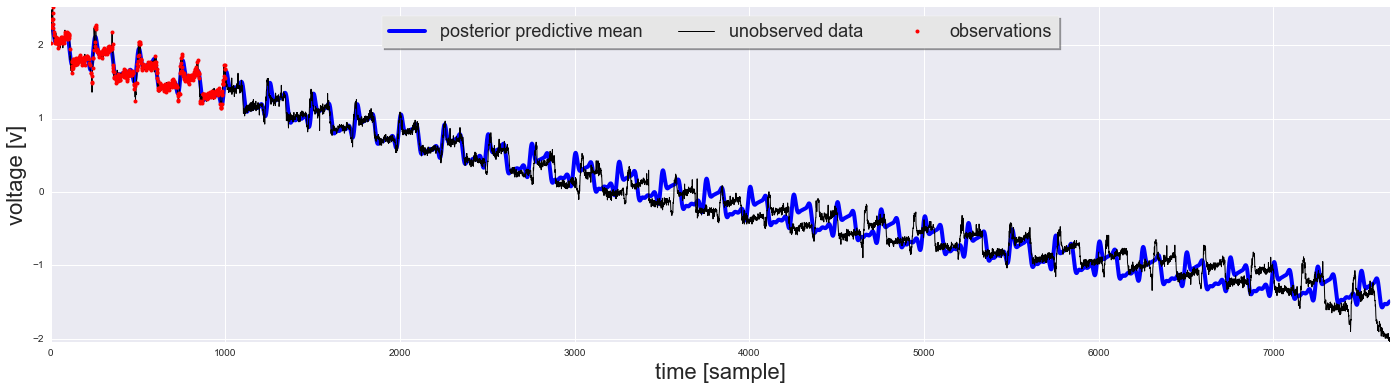

In [32]:
#graficar estimación, observaciones y datos reales
fsize = 22
fig=plt.figure(9, figsize=(24,6))
ax = plt.gca()
plt.plot(t,y_model_trend,'b',label='posterior predictive mean',linewidth=4)
plt.fill_between(t,y_model_trend-2*std_dev-2*sigma_y_GP_test*0, y_model_trend+2*std_dev+2*sigma_y_GP_test*0, facecolor='blue', alpha=0.2)
plt.plot(t,f, color='black',ls='-',label='unobserved data',linewidth=1)
plt.plot(t_obs,y_trend_comp,color='red', marker='.', linestyle='None',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9,prop={'size':18})
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]', size = fsize)
plt.ylabel('voltage [v]', size = fsize)
#plt.title('title', size = fsize)
plt.axis('tight')
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
#plt.title('Signal recovery using 15% of observations')
plt.savefig("Per.png",format='png', dpi=300, bbox_inches='tight')

In [33]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_Per=0
params0=np.asarray([sigma_y_GP_test,  gamma_test,  sigma_test, per_test])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
#minimize(J,x0[i],args=(y),method=method,jac=jac)
opt = {'disp':1,'maxiter':50}
#res=minimize(like_Per,X0, args=args,method='L-BFGS-B',jac=like_Per_Df,tol=0.00000001/(2.22E-12),options=opt)
res=minimize(like_Per,X0, args=args,method='L-BFGS-B',jac=like_Per_Df,options=opt)
#res=minimize(like_Per,X0, args=args,method='Nelder-Mead',jac=False,tol=0.00000001/(2.22E-12),options=opt)
time_GP=time.time()-time_GP
time_Per = time_GP
sigma_y_GP_test, gamma_test, sigma_test, per_test = np.exp(res.x)
print('Hiperparametros encontrados: ', np.exp(res.x), 'NLL: ', res.fun)
print('Tiempo transcurrido %f' %time_Per)

('Condicion inicial optimizador: ', array([   1. ,    3. ,    0.3,  250. ]))
True
1.0
1.0
0.0
(1.0, 3.0000000000000004, 0.29999999999999999, 249.99999999999989)
True
1.0
1.0
0.0
True
0.135335438185
0.367879651767
0.0
(0.36787965176740123, 3.0000000000000004, 0.29967916919777987, 249.99999999999989)
True
0.135335438185
0.367879651767
0.0
True
4.54001896563e-05
0.00673796628511
0.0
(0.0067379662851052187, 3.0000000000000004, 0.29839927340166206, 249.99999999999989)
True
4.54001896566e-05
0.00673796628511
0.0
True
0.0126939275585
0.112667331372
0.0
(0.1126673313721207, 3.0000000000000004, 0.29929996783868279, 249.99999999999989)
True
0.0126939275585
0.112667331372
0.0
True
0.000109153622702
0.0104476611117
0.0
(0.010447661111722918, 3.0000000000000004, 0.30024806327780501, 249.99999999999989)
True
0.000109153622703
0.0104476611117
0.0
True
0.00407842540717
0.0638625508978
0.0
(0.063862550897762188, 3.0000000000000004, 0.29952603099035102, 249.99999999999989)
True
0.00407842540717
0.063862

In [34]:
cov=Per_diag(t,t,gamma=gamma_test,sigma=sigma_test,per=per_test)
cov_obs=Per(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test,per=per_test)
K_star=Per(t,t_obs,gamma=gamma_test,sigma=sigma_test,per=per_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
Gram = cov_obs+sigma_y_GP_test**2*np.identity(N_obs)
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

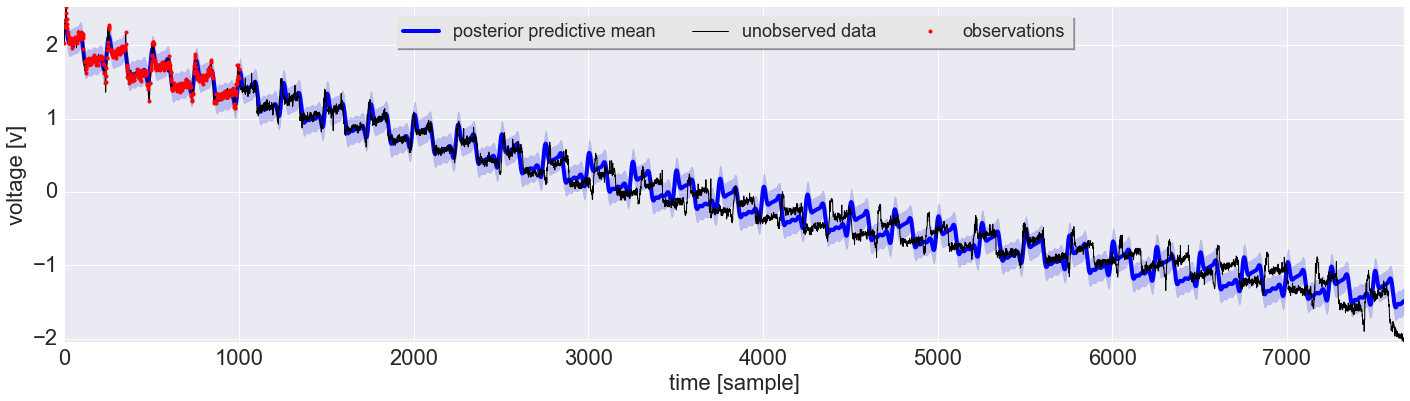

In [35]:
#graficar estimación, observaciones y datos reales
fsize = 22
fig=plt.figure(10, figsize=(24,6))
ax = plt.gca()
plt.plot(t,y_model_trend,'b',label='posterior predictive mean',linewidth=4)
plt.fill_between(t,y_model_trend-2*std_dev-2*sigma_y_GP_test, y_model_trend+2*std_dev+2*sigma_y_GP_test, facecolor='blue', alpha=0.2)
plt.plot(t,f, color='black',ls='-',label='unobserved data',linewidth=1)
plt.plot(t_obs,y_trend_comp,color='red', marker='.', linestyle='None',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9,prop={'size':18})
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]', size = fsize)
plt.ylabel('voltage [v]', size = fsize)
#plt.title('title', size = fsize)
plt.axis('tight')
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
#plt.title('Signal recovery using 15% of observations')
plt.savefig("Per_post.png",format='png', dpi=300, bbox_inches='tight')

In [36]:
def LocPer(x, y, gamma1, gamma2, sigma, per):
    sx=np.size(x); sy=np.size(y)
    K = np.zeros([sx,sy])
#    print(sx)
#    print(sy)
    for i in range(sx):
        for j in range(sy):
            arg1 = np.sin(np.pi*np.abs(x[i]-y[j])/per)**2
            arg2 = gamma2*(x[i]-y[j])**2
            K[i,j] = np.exp(-2*gamma1*(arg1) - arg2)
    return sigma**2*K 

def LocPer_diag(x, y, gamma1, gamma2, sigma, per):
    sx=np.size(x); sy=np.size(y)
    K = np.zeros([sx,sy])
#    print(sx)
    for i in range(sx):
        arg1 = np.sin(np.pi*np.abs(x[i]-y[i])/per)**2
        arg2 = gamma2*(x[i]-y[i])**2
        K[i,i] = np.exp(-2*gamma1*(arg1) - arg2)
    return sigma**2*K 
def like_LocPer(X, y, t): 
    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
	sigma_un, gamma_1,gamma_2, sigma_1, per_1 = np.exp(X)     
	Gram=LocPer(t,t,gamma_1,gamma_2,sigma_1,per_1)+sigma_un**2*np.identity(len(t));
	check = np.linalg.eigvalsh(Gram)
	print(np.all(check>0))
	print(np.min(check))
	print(sigma_un)
#	print(np.shape(Gram))
#	print(Gram[:3,:3])
	print(sigma_un, gamma_1,gamma_2, sigma_1, per_1)
	cGg = sc.linalg.cholesky(Gram, lower=True)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	#invGram=np.linalg.inv(Gram)
	nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
	return 0.5*nll+0.5*len(y)*np.log(2*pi)

#derivative of negative log-likelihood when using Per kernel
def like_LocPer_Df(X, y, t):
	sigma_un, gamma_1,gamma_2, sigma_1, per_1 = np.exp(X)
	per_1 = 1/per_1    
	sigma_1 = 0.3e0
	Gram0=LocPer(t,t,gamma_1,gamma_2,sigma_1,per_1)
	Gram=Gram0+sigma_un**2*np.identity(len(t));
	check = np.linalg.eigvalsh(Gram)
	print(np.all(check>0))
	print(np.min(check))
	print(sigma_un)
#	print(np.shape(Gram))
#	print(Gram[:3,:3])
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	#invGram = np.linalg.norm(Gram)
	A=np.dot(invGram,y)
	outer_sub=outersum(t,-t) 
	q = np.pi*per_1*outer_sub
	z1 = -2*gamma_1*np.sin(q)
	z2 = - gamma_2*outer_sub**2
	z = z1+z2
	D1= 2*sigma_un**2*np.identity(len(t)) #sigma_un
	D2= -Gram0*z1/gamma_1*sigma_1**2 #gamma_1
	D3= 2*Gram0*sigma_1**2 #sigma_1
	D4= 4*Gram0*gamma_1*np.sin(q)*np.cos(q)*q/per_1*sigma_1**2 #per_1
	D5= -Gram0*z2/gamma_1*sigma_1**2

	B=np.outer(A,A)-invGram
	d1=  -np.trace(np.dot(B,D1))
	d2=  -np.trace(np.dot(B,D2))
	d3=  -np.trace(np.dot(B,D3))
	d4=  0#-np.trace(np.dot(B,D4))
	d5=  -np.trace(np.dot(B,D5))
   	#print(['Derivatives: ', d1, d2, d3])
	return np.asarray([0.5*d1, 0.5*d2, 0.5*d3, 0.5*d4, 0.5*d5])

In [37]:
#elegir hiperparámetros
sigma_y_GP_test = 1e0#0.2
gamma1_test = 3e0#0.001
gamma2_test = 7e-7
sigma_test = 0.3e0#0.5
per_test = 2.5e2#0.5

(1, 7669)


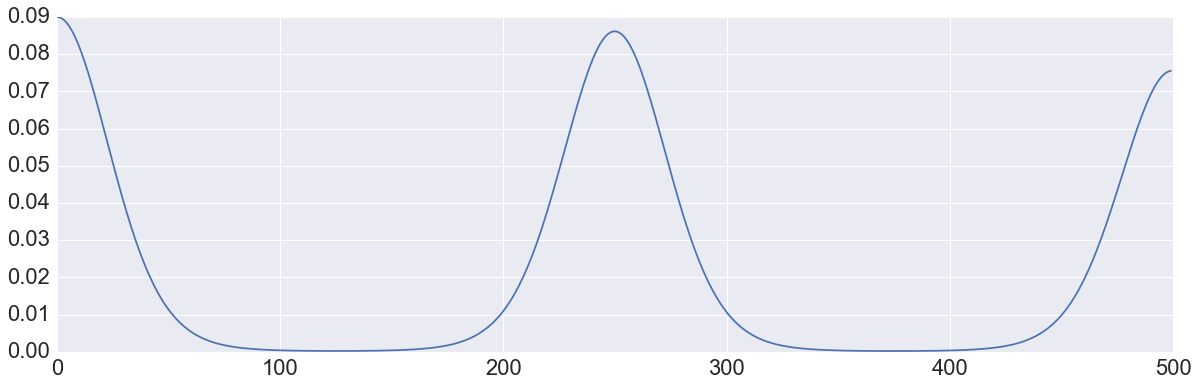

In [38]:
fig=plt.figure(11, figsize=(20,6))
#plt.plot(Per(np.array([0]),t,gamma=gamma_test,sigma=sigma_test,per=per_test))
print np.shape(LocPer(np.array([0]),t,gamma1=gamma1_test,gamma2=gamma2_test,sigma=sigma_test,per=per_test))
aux = LocPer(np.array([0]),t,gamma1=gamma1_test,gamma2=gamma2_test,sigma=sigma_test,per=per_test)
plt.plot(aux[0][:500])

In [39]:
#NLL para la elección de hiperparámetros 
print(like_LocPer([sigma_y_GP_test, gamma1_test,gamma2_test, sigma_test, per_test], y_obs, t_obs))


cov=LocPer_diag(t,t,gamma1=gamma1_test,gamma2=gamma2_test,sigma=sigma_test,per=per_test)
cov_obs=LocPer(t_obs,t_obs,gamma1=gamma1_test,gamma2=gamma2_test,sigma=sigma_test,per=per_test)
K_star=LocPer(t,t_obs,gamma1=gamma1_test,gamma2=gamma2_test,sigma=sigma_test,per=per_test)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
Gram = cov_obs+sigma_y_GP_test**2*np.identity(N_obs)
#invGramg = np.linalg.inv(Gram)
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)
y_model_trend = y_model+y_trend
print("Done")

True
7.98160015339
2.71828182846
(2.7182818284590451, 20.085536923187668, 1.0000007000002451, 1.3498588075760032, 3.7464546145026734e+108)
1014.59155562
Done


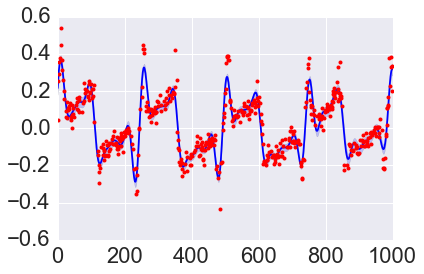

True
7.98160015339
2.71828182846
(2.7182818284590451, 20.085536923187668, 1.0000007000002451, 1.3498588075760032, 3.7464546145026734e+108)
1014.59155562


In [40]:
plt.plot(t[:Ns],y_model[:Ns],'b',label='predicted mean')
plt.fill_between(t[:Ns],y_model[:Ns]-2*std_dev[:Ns], y_model[:Ns]+2*std_dev[:Ns], facecolor='blue', alpha=0.2)
plt.plot(t_obs,y[i_obs]-y_trend[i_obs],'r.',ms=8,label='observations')
#plt.plot(y_model)
#plt.plot(y[:500]-y_trend[:500])
plt.show()
print(like_LocPer([sigma_y_GP_test, gamma1_test,gamma2_test, sigma_test, per_test], y_obs, t_obs))

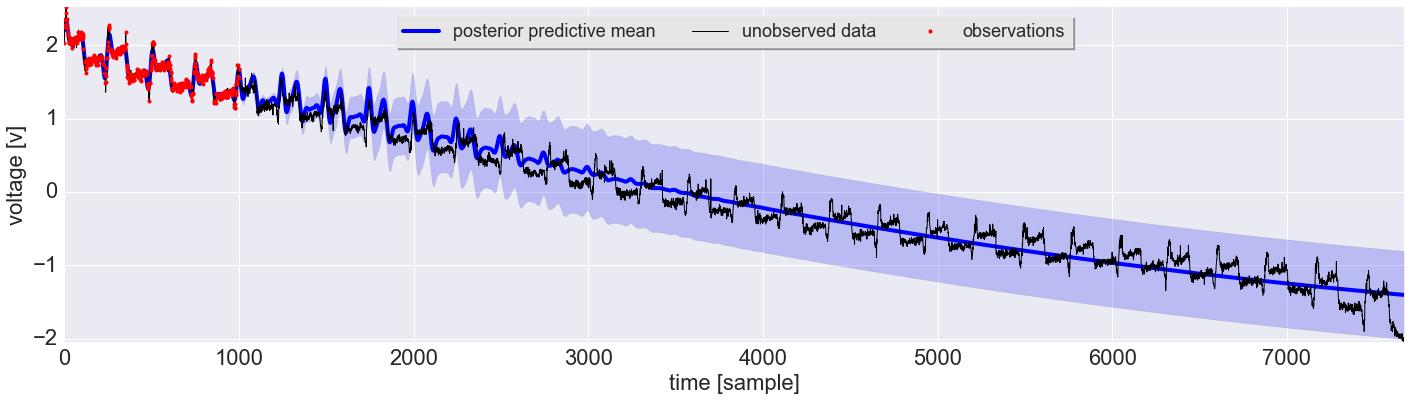

In [41]:
#graficar estimación, observaciones y datos reales
fsize = 22
fig=plt.figure(12, figsize=(24,6))
ax = plt.gca()
plt.plot(t,y_model_trend,'b',label='posterior predictive mean',linewidth=4)
plt.fill_between(t,y_model_trend-2*std_dev-2*sigma_y_GP_test*0, y_model_trend+2*std_dev+2*sigma_y_GP_test*0, facecolor='blue', alpha=0.2)
plt.plot(t,f, color='black',ls='-',label='unobserved data',linewidth=1)
plt.plot(t_obs,y_trend_comp,color='red', marker='.', linestyle='None',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9,prop={'size':18})
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]', size = fsize)
plt.ylabel('voltage [v]', size = fsize)
#plt.title('title', size = fsize)
plt.axis('tight')
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
#plt.title('Signal recovery using 15% of observations')
plt.savefig("LocPer.png",format='png', dpi=300, bbox_inches='tight')

In [42]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_LocPer=0
params0=np.asarray([sigma_y_GP_test, gamma1_test,gamma2_test, sigma_test, per_test])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
#minimize(J,x0[i],args=(y),method=method,jac=jac)
opt = {'disp':1,'maxiter':50}
#res=minimize(like_Per,X0, args=args,method='L-BFGS-B',jac=like_Per_Df,tol=0.00000001/(2.22E-12),options=opt)
res=minimize(like_LocPer,X0, args=args,method='L-BFGS-B',jac=like_LocPer_Df,options=opt)
#res=minimize(like_Per,X0, args=args,method='Nelder-Mead',jac=False,tol=0.00000001/(2.22E-12),options=opt)
time_GP=time.time()-time_GP
time_LocPer = time_GP
[sigma_y_GP_test, gamma1_test,gamma2_test, sigma_test, per_test] = np.exp(res.x)
print('Hiperparametros encontrados: ', np.exp(res.x), 'NLL: ', res.fun)
print('Tiempo transcurrido %f' %time_LocPer)

('Condicion inicial optimizador: ', array([  1.00000000e+00,   3.00000000e+00,   7.00000000e-07,
         3.00000000e-01,   2.50000000e+02]))
True
1.0
1.0
(1.0, 3.0000000000000004, 6.9999999999999965e-07, 0.29999999999999999, 249.99999999999989)
True
1.0
1.0
True
0.135335299722
0.367879463577
(0.36787946357705886, 3.0000000000000004, 6.9975632741588834e-07, 0.29999999999999999, 250.00607860981563)
True
0.13533529964
0.367879463577
True
3.62010523282e-07
0.000601673105342
(0.00060167310534237463, 2.9999999999999996, 6.1071791822109277e-07, 0.29999999999999999, 252.0272444382376)
True
3.61942640342e-07
0.000601673105342
True
0.00193222138584
0.0439570402307
(0.043957040230671984, 3.0000000000000004, 6.6892013904035473e-07, 0.29999999999999999, 250.67357096096222)
True
0.00193222130583
0.0439570402307
True
0.0948711673507
0.30801163509
(0.30801163508978441, 3.0000000000000004, 6.9712476712928689e-07, 0.29999999999999999, 250.06181471155878)
True
0.094871167286
0.30801163509
True
0.0124430

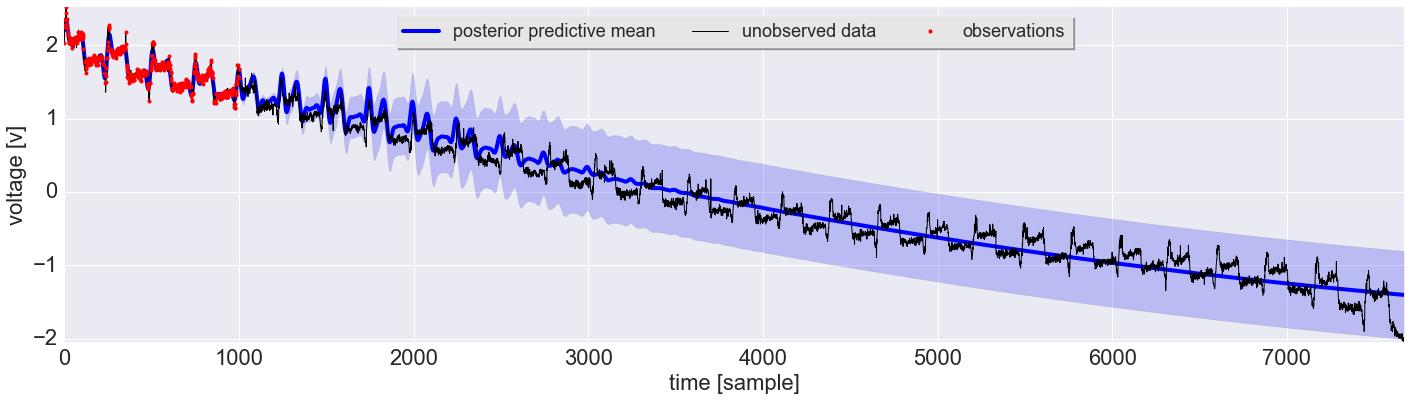

In [43]:
#graficar estimación, observaciones y datos reales
fsize = 22
fig=plt.figure(13, figsize=(24,6))
ax = plt.gca()
plt.plot(t,y_model_trend,'b',label='posterior predictive mean',linewidth=4)
plt.fill_between(t,y_model_trend-2*std_dev-2*sigma_y_GP_test*0, y_model_trend+2*std_dev+2*sigma_y_GP_test*0, facecolor='blue', alpha=0.2)
plt.plot(t,f, color='black',ls='-',label='unobserved data',linewidth=1)
plt.plot(t_obs,y_trend_comp,color='red', marker='.', linestyle='None',ms=8,label='observations')
leg=plt.legend(ncol=4,frameon=True, shadow=True, loc=9,prop={'size':18})
frame  = leg.get_frame()
frame.set_facecolor('0.9')
plt.xlabel('time [sample]', size = fsize)
plt.ylabel('voltage [v]', size = fsize)
#plt.title('title', size = fsize)
plt.axis('tight')
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
#plt.title('Signal recovery using 15% of observations')
plt.savefig("LocPer_post.png",format='png', dpi=300, bbox_inches='tight')